# Computer Lab 1: k-NN classifier

## Exercise 1 – Synthetic dataset 
 
In this exercise, you will employ a synthetic dataset (file `synthetic.mat` in `/data/` folder), containing labelled training data and test data for two classes. Each example is 2-dimensional. 
 
**Task**: your task is to implement a k-NN classifier in Matlab, which calculates the probability that a given test example belongs to each class, and outputs a class label as the class with the highest  probability. You will evaluate the classifier performance computing the average classification accuracy (i.e. the fraction of test examples that have been classified correctly).
 
In particular, you should perform the following:
* Train a k-NN classifier for different values of k. 
* Compare accuracy on the training set and the test set. Calculating accuracy of the training  set means that you will have to classify each sample in the training set as if it were a test sample; one expects that classification of training samples will perform well, and this may also be used to validate your implementation. 
    * Accuracy is defined as the ratio between the number of test samples that are correctly classified, and the total number of test samples. 
* Identifying overfitting and underfitting in the obtained results. 
 
Note that, for this computer lab, you do not need to employ a validation set.

## k-NN Classifier: Theory

* Classification
    * This is a supervised learning approach, since there are some classes (2 in this particular case, then binary classification task) among them the algorithm must choose for each data input.
* k-NN: k-th Nearest Neighboors
    * Supervised learning algorithm
        * Within the test set, the algorithm identifies the k-nearest neighbors for each data point. Subsequently, it assigns the label to each data point in the test set based on the prevalent label among its k-nearest neighbors in the train set.
        * Metrics: to compute the nearest neighboors can be choosen any metrics to calculate "distance" between data points. Since in this case the data points are 2-dimensional, it has been used the Euclidean distance $d_{p_1,p_2}=\sqrt{(x_2-x_1)^2+(y_2-y_1)^2}$.
    * Non-parametric algorithm: no prior assumptions on data points distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io
import seaborn as sns
from tqdm import tqdm

# Plots
sns.set_context(
    'talk', rc = {
        'font.size': 12.0,
        'axes.labelsize': 10.0,
        'axes.titlesize': 10.0,
        'xtick.labelsize': 10.0,
        'ytick.labelsize': 10.0,
        'legend.fontsize': 10.0,
        'legend.title_fontsize': 12.0,
        'patch.linewidth': 2.0
        }
    ) # 'paper'

data_sets = ['Train', 'Test']

In [2]:
# Check current folder
os.getcwd()

'/'

In [3]:
data_path = '/Users/ernestocolacrai/Documents/GitHub/StatisticalLearning/data/synthetic.mat'

try:
    data = scipy.io.loadmat(data_path)
    print(f"Data ✓")
    print(f"Data Keys: {data.keys()}")
except:
    print(f"Not found data! ({data_path})")

Data ✓
Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'knnClassify2dTest', 'knnClassify2dTrain'])


In [4]:
data_df = {}

for d_type in data_sets:
    data_df[d_type] = pd.DataFrame(
        {'x': data[f'knnClassify2d{d_type}'][:,0],
        'y': data[f'knnClassify2d{d_type}'][:,1],
        'label': data[f'knnClassify2d{d_type}'][:,2]
        }
    )
    print(f"{d_type} ({len(data_df[d_type])} data points) ✓")
    print(f"{d_type} data types:\n{data_df[d_type].dtypes}\n")

data_df['Train'].head()

Train (100 data points) ✓
Train data types:
x        float64
y        float64
label    float64
dtype: object

Test (100 data points) ✓
Test data types:
x        float64
y        float64
label    float64
dtype: object



,x,y,label
0,2.1627,3.8666,1.0
1,2.0862,2.8266,1.0
2,1.8345,4.6970,1.0
3,2.6564,3.5323,1.0
4,3.9049,1.4013,1.0


In [5]:
# Check for NaN values
for d_type in data_sets:
    print(f"{d_type}:\n{data_df[f'{d_type}'].isna().sum(axis=0)}\n")

Train:
x        0
y        0
label    0
dtype: int64

Test:
x        0
y        0
label    0
dtype: int64



In [6]:
# Label = 1 or 2, then it is sufficient to use a 'int8' data type
for d_type in data_sets:
    data_df[d_type].label = data_df[d_type].label.astype('int8')

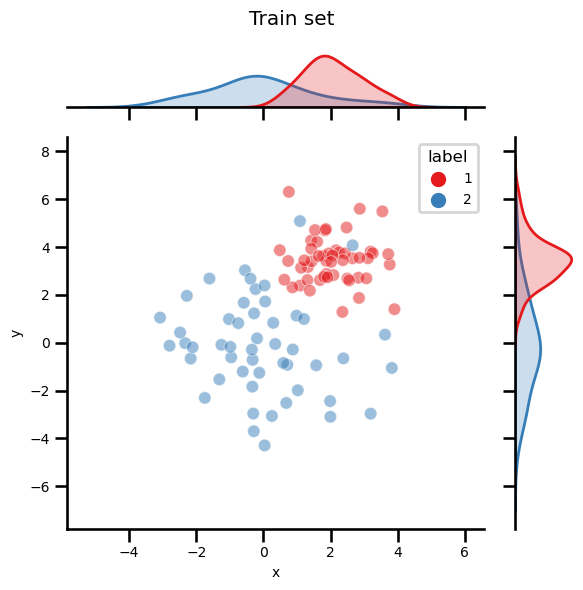

In [7]:
p = sns.jointplot(
        data=data_df['Train'], x='x', y='y',
        hue='label',
        palette='Set1', alpha=0.5
        )
p.fig.suptitle(r"Train set")
p.fig.tight_layout()

In [8]:
def euclidean(point1: np.ndarray, point2: np.ndarray) -> float:
    """
    This function calculates the Euclidean distance between two points represented as NumPy arrays.

    Args:
        point1 (np.ndarray): A NumPy array representing the first point. It should have two dimensions.
        point2 (np.ndarray): A NumPy array representing the second point. It should have two dimensions.

    Returns:
        float: The Euclidean distance between the two points.
    """
    # Assert that both input arrays are NumPy arrays
    assert isinstance(point1, np.ndarray), "The first input array should be a NumPy array."
    assert isinstance(point2, np.ndarray), "The second input array should be a NumPy array."

    # Assert that both arrays have two dimensions
    assert point1.shape[0] == 2, "The first input array should have two dimensions."
    assert point2.shape[0] == 2, "The second input array should have two dimensions."

    # Assert that the arrays have the same dimensions
    assert point1.shape == point2.shape, "The two input arrays should have the same dimensions."
    
    # Calculate the squared differences between corresponding elements of the two points
    squared_differences = (point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2

    # Calculate the Euclidean distance by taking the square root of the sum of squared differences
    return round(np.sqrt(squared_differences), 4)

* k-NN algorithm:
    * $\forall\ \mathbf{y}\in\mathcal{D}_{\text{TEST}}$
        * $\forall\ \mathbf{x}\in\mathcal{D}_{\text{TRAIN}}$
            * $d_{\mathbf{x},\mathbf{y}}=\sqrt{(y_1-x_1)^2 + (y_2 - x_2)^2}$
        * Select k-th points in train-set with the lowest distances associated to $\mathbf{y}$
        * Predicted label: $l_1 \dot{=}\frac{1}{k}\sum_{i=1}^k\mathbb{I}(l_{\mathbf{x}_i}=1)$
            * $l_{\mathbf{y}}=\begin{cases}1 & l_1 \geq \frac{k}{2} \\ 2 & \text{otherwise}\end{cases}$

**Problems**
* $|\mathcal{D}_{\text{TRAIN}}|=|\mathcal{D}_{\text{TEST}}|=N$
* $\forall \mathbf{y}\in\mathcal{D}_{\text{TEST}}$: $\mathcal{O}(N)$
    * $\mathbf{x}\in\mathcal{D}_{\text{TRAIN}}$: $\mathcal{O}(N)$
* Select k-th points with lowest distances: $\mathcal{O}(N)$ if data is stored in an array-like data structure
 * Overall: $\propto\mathcal{O}(N^2)$, maybe inefficient approach!

In [9]:
def knn(train_set: pd.core.frame.DataFrame, test_set: pd.core.frame.DataFrame, k: int = 3) -> pd.core.frame.DataFrame:

    """
    This function implements the k-nearest neighbors classification algorithm for classifying data points from a test set based on a training set.

    Args:
        train_set (pd.DataFrame): A pandas DataFrame containing the training data. It should have the following columns: 'x', 'y', and 'label'.
        test_set (pd.DataFrame): A pandas DataFrame containing the test data. It should have the columns 'x' and 'y'.
        k (int, optional): The number of nearest neighbors to consider for classification. Defaults to 3.

    Returns:
        pd.DataFrame: The modified test_set with an additional column 'prediction', indicating the predicted class for each data point.
    """

    # Validate input data frames
    for col in ["x", "y", "label"]:
        assert col in train_set.columns, f"Train set must have '{col}' column."
        assert col in test_set.columns, f"Test set must have '{col}' column."

    # Initialize data structures
    M = len(test_set)  # Number of data points in the training set
    N = len(train_set)  # Number of data points in the test set

    # Validate k parameter
    assert (type(k) != float) and (k % 2 == 1), "k parameter should be an odd integer number."
    assert k < N, "k parameter should be smaller than the train set size."

    # Initialize 'prediction' column in test set
    test_set['prediction'] = 0
    
    D = np.zeros([M, N], dtype=float)  # Distance matrix
    E = np.zeros([M, k], dtype=int)  # Array of nearest neighbors

    # Calculate distances between test set points and training set points
    for i in np.arange(0, M, 1):  # For each test point
        for j in np.arange(0, N, 1):  # For each training point
            D[i][j] = euclidean(  # Calculate distance between the points
                test_set.loc[i][['x', 'y']].values,  # Current test point coordinates
                train_set.loc[j][['x', 'y']].values  # Corresponding training point coordinates
            )

        # Find the k nearest neighbors for each test point
        E[i] = np.argsort(D[i])[:k]  # Obtain the indices of the k nearest neighbors

        # Assign predictions based on majority of labels among the k nearest neighbors
        l1 = np.sum([int(train_set.loc[E[i][idx]].label == 1) for idx in np.arange(0, k)]) >= (k + 1) / 2
        l2 = np.sum([int(train_set.loc[E[i][idx]].label == 2) for idx in np.arange(0, k)]) >= (k + 1) / 2

        if l1:
            test_set.loc[i, 'prediction'] = 1
        elif l2:
            test_set.loc[i, 'prediction'] = 2

    return test_set  # Return the modified test set with predictions


In [10]:
def knn_accuracy(test_set: pd.core.frame.DataFrame) -> float:
    return 1 - len(test_set[test_set.label != test_set.prediction]) / len(test_set)

In [11]:
k_vals = np.arange(1, 100, 2)
misclass_errs = []
for k in tqdm(k_vals, colour="green"):
    misclass_errs.append(1 - knn_accuracy(knn(data_df['Train'], data_df['Test'], k)))

100%|██████████| 50/50 [02:13<00:00,  2.67s/it]


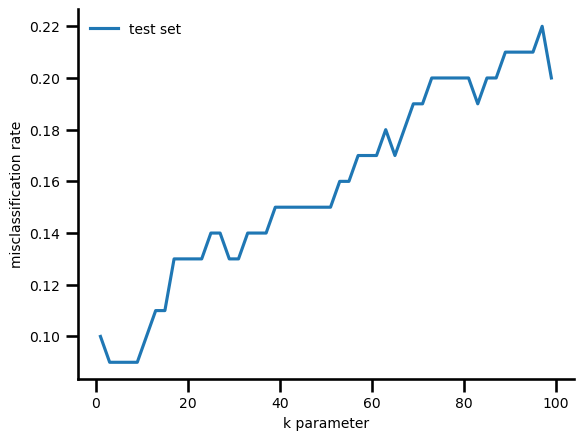

In [23]:
p = sns.lineplot(x=k_vals, y=misclass_errs)
p.legend(['test set'], framealpha=0)
p.set_ylabel('misclassification rate')
p.set_xlabel('k parameter')
#p.set_xticks(k_vals)
#p.tick_params('x', rotation=0, labelsize=8)
sns.despine(right=True)

In [33]:
# Implementation by using sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Instantiate learning model (k = 3)
neig = KNeighborsClassifier(n_neighbors=3)

# Fitting the model
neig.fit(data_df['Train'][['x', 'y']].values, data_df['Train'].label.values)

# Predict the response
pred = neig.predict(data_df['Test'][['x', 'y']].values)

# Evaluate accuracy
print("accuracy: {}".format(accuracy_score(data_df['Test'].label.values, pred)))

accuracy: 0.91
